* **Nombre de la Entrega:** Actividad Semana 4 - Aplicando PCA
* **Integrantes:**
- Rafael J. Mateo C: A01793054
- Matthias Sibrian: A01794249 

* **Materia:** Ciencia y Analítica de Datos
* **Profesor:** Jobish Vallikavungal Devassia 

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns

In [18]:
df = pd.read_csv("clean-dataset.csv")
df.head()

,ID,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,1,20000,2.0,2.0,1.0,24.0,2.0,2.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1.0
1,2,120000,2.0,2.0,2.0,26.0,-1.0,2.0,0.0,0.0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1.0
2,3,90000,2.0,2.0,2.0,34.0,0.0,0.0,0.0,0.0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0.0
3,4,50000,2.0,2.0,1.0,37.0,0.0,0.0,0.0,0.0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0.0
4,5,50000,1.0,2.0,1.0,57.0,-1.0,0.0,-1.0,0.0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0.0


#### **Paso 1: Determine el número mínimo de componentes principales que representan la mayor parte de la variación en sus datos**



Los componentes principales es una técnica utilizada para reducir las dimensiones o factores de un conjunto de datos, pero minimizando la pérdida de informaición. Esta información puede interpretarse como la varianza en el conjunto de datos. Por tanto, el objetivo del PCA es poder reducir las dimensiones a una serie de componentes con la manteniendo la mayor parte de las varianzas de los datos originales.

PCA también se utiliza cuando existe correlación entre las variables de entrada, ya que los componentes arrojados por la técnica PCA no tienen una correlación.

Bien, ahora empecemos el ejercicio explorando la relación entre las variables, calculando el coeficiente de correlación y graficándolo en un heatmap.

<AxesSubplot: >

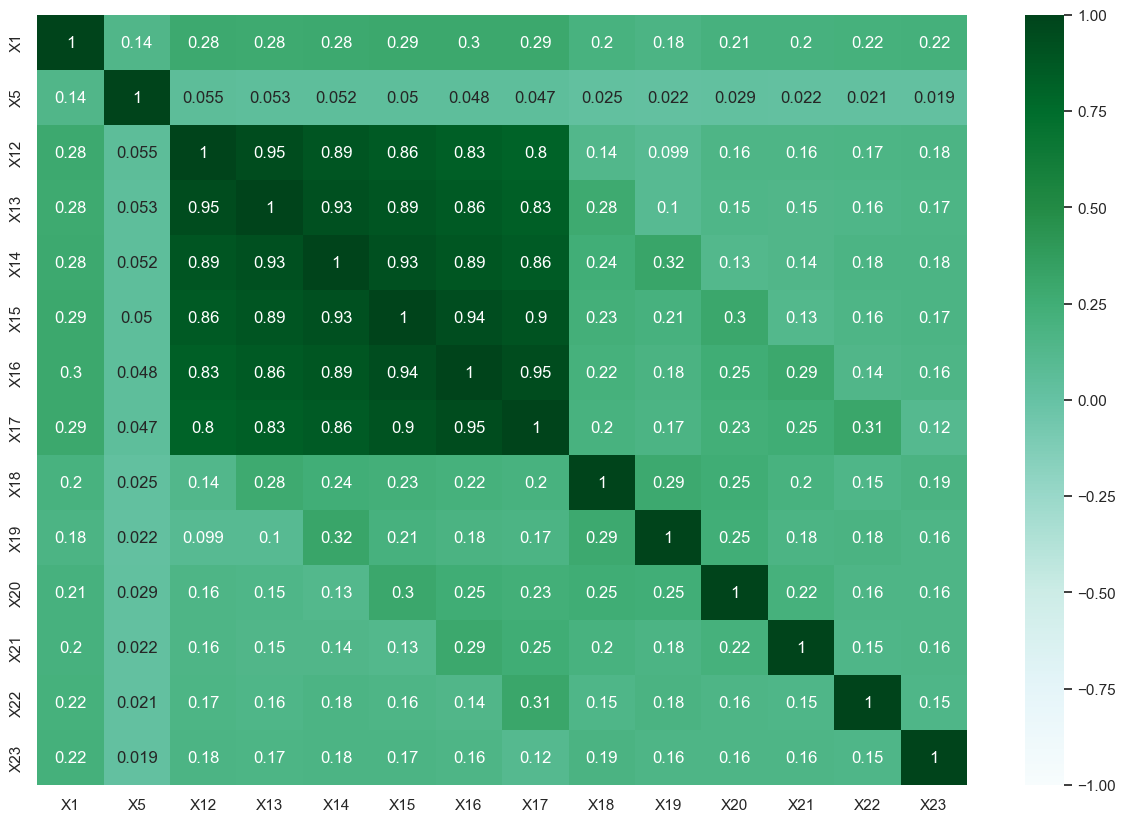

In [19]:
#Solo nos interesa las variables continuas, por tanto obviamos las categóricas
continous_attrs = ["X1", "X5", "X12", "X13", "X14", "X15", "X16","X17", "X18", "X19", "X20", "X21", "X22", "X23"]

sns.set(rc = {'figure.figsize':(15,10)})
sns.heatmap(df[continous_attrs].corr(), vmin=-1, vmax=1, cmap="BuGn", annot = True )

Del gráfico anterior se puede observar una correlación fuerte entre las variables X12 a X17, las cuales hace referencia al valor del estado de cuenta para cada mes. Esta correlación hace sentido, ya que se puede esperar que el valor de lo consumido entre un mes y el siguiente sea muy parecido. 

En conclusión, el gráfico anterior muestra la existencia de correlación entre las variables y eso justifica la realización del PCA, además de la necesidad de disminuir las dimensiones.

Ahora veamos la constribución de las varianzas para cada una de las variables de estudio, escalando primero los datos ya que el orden de magnitud es muy diferente entre algunas variables (por ejemplo, edad y monto del estado de cuenta). De no hacer el escalamiento de los datos, las variables con un orden de magnitud mayor afectarán considerablemente el resultado de este ejercicio.

In [20]:
df_copy = df[continous_attrs].copy() #Realizamos una copia para no afectar los datos originales

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_df = scaler.fit_transform(df_copy[continous_attrs]) #Estandarizamos los datos para que la media sea cero y la varianza 1
scaled_df = pd.DataFrame(scaled_df, columns = continous_attrs) #Colocamos los datos en un dataframe para menor visualización

total_var =scaled_df.var().sum()

df_vars = pd.DataFrame({
    "Variance": scaled_df.var()/ total_var, #Calculamos las varianzas de cada variable, las cuales se esperan que sean las mismas
    "Cumulative": scaled_df.var().cumsum() / total_var #Calculamos el acumulado de las varianzas
})

df_vars

,Variance,Cumulative
X1,0.071429,0.071429
X5,0.071429,0.142857
X12,0.071429,0.214286
X13,0.071429,0.285714
X14,0.071429,0.357143
X15,0.071429,0.428571
X16,0.071429,0.500000
X17,0.071429,0.571429
X18,0.071429,0.642857
X19,0.071429,0.714286


De la tabla anterior se observa que 11 de las variables explican aproximadamente el 80% de la variación. Ahora investiguemos cuáles son los componentes principales.

In [22]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

pca_pipe = Pipeline(steps = [
    ("scaler", StandardScaler()),
    ("PCA", PCA())
]) #Creamos un pipeline para aplicar el scaler y pca a los datos originales

col_transf = ColumnTransformer ([
    ("pca-transf", pca_pipe, continous_attrs),
], remainder="passthrough") #Usamos el ColumnTransformer para aplicar el pipe solo a los datos continuos

transf = col_transf.fit_transform(df_copy) #Obtenemos los datos transformados

pcs = col_transf.named_transformers_["pca-transf"]["PCA"] # Extraemos el objeto PCA para poder usar sus atributos mas adelante

In [23]:
components_labels = [f'PC{i + 1}' for i in range(len(continous_attrs))] #Creamos los labels para los componentes

pcsSummary = pd.DataFrame({
                          'Attr': components_labels,
                          'Standard deviation': np.sqrt(pcs.explained_variance_),
                          'Proportion of variance': pcs.explained_variance_ratio_,
                          'Cumulative proportion': np.cumsum(pcs.explained_variance_ratio_)
                          }) #Se obtiene la info de la Desv Std, proporción de la varianza explicada y el acumulado de esta para cada componente
pcsSummary

,Attr,Standard deviation,Proportion of variance,Cumulative proportion
0,PC1,2.433504,0.422981,0.422981
1,PC2,1.311512,0.122858,0.545839
2,PC3,1.022239,0.074638,0.620477
3,PC4,0.962027,0.066105,0.686582
4,PC5,0.940169,0.063135,0.749717
5,PC6,0.934346,0.062355,0.812072
6,PC7,0.882630,0.055644,0.867716
7,PC8,0.851808,0.051825,0.919541
8,PC9,0.840610,0.050472,0.970012
9,PC10,0.510782,0.018635,0.988647


Como se observa en el cálculo que acabos de realizar, se requieren 8 componentes para obtener más del 90% de la información y 6 componentes para obtener más del 80% de la información. Lo anterior puede confirmarse con  el Scree Plot, como veremos a continuación.

Text(0, 0.5, 'Explained Variance')

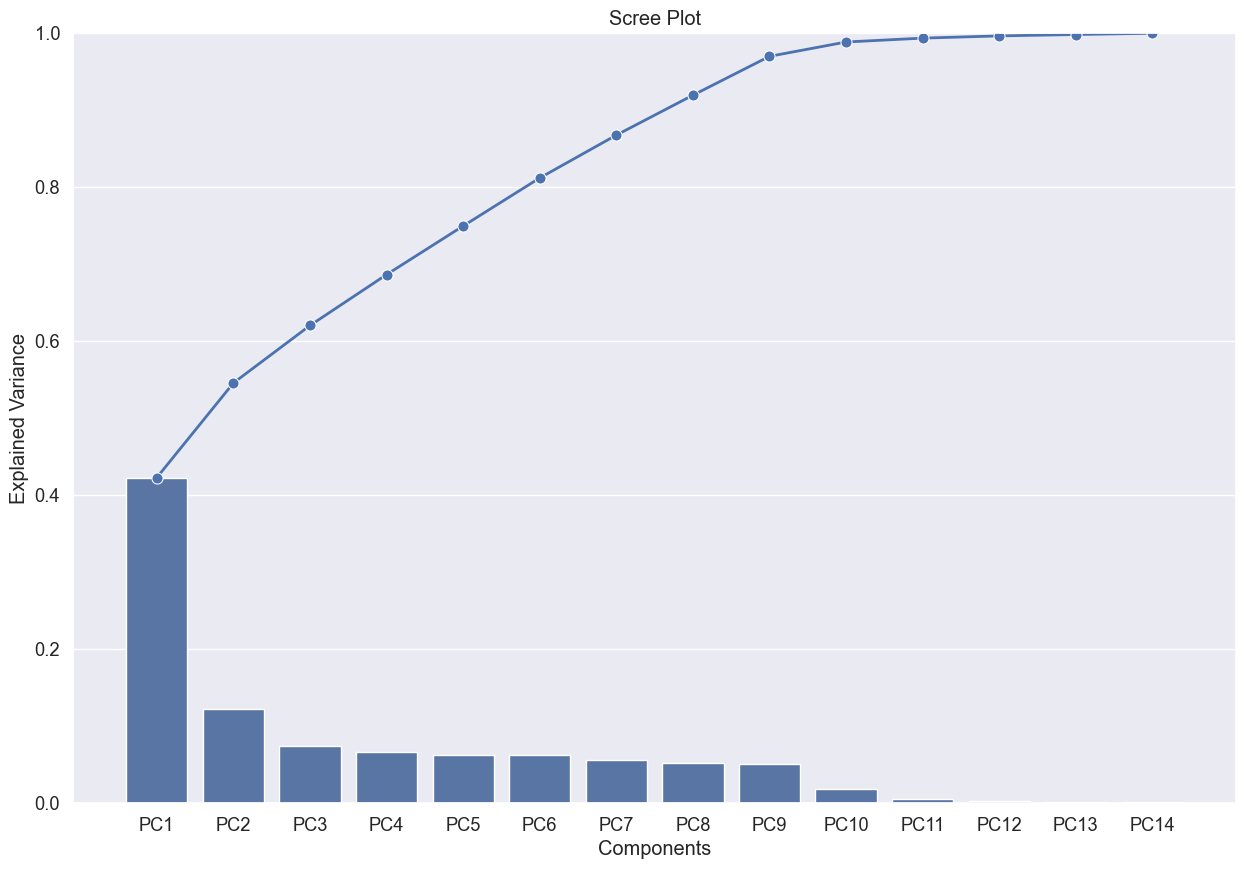

In [24]:
import matplotlib.pyplot as plt

sns.set(font_scale = 1.2)
sns.barplot(x = components_labels, y = pcs.explained_variance_ratio_, color = 'b')
sns.lineplot(
    x = components_labels, 
    y = np.cumsum(pcs.explained_variance_ratio_),
    marker= "o",
    markersize = 8,
    linewidth = 2,
    linestyle = "-")

plt.ylim(0,1)
plt.title("Scree Plot")
plt.xlabel("Components")
plt.ylabel("Explained Variance")

Para continuar con el ejercicio, estaremos usando los primeros 6 componentes como los principales, ya que estos explican el 80% de la variación de los datos.

#### **Paso 2: Interprete cada componente principal en términos de las variables originales**

Ahora exploremos los componentes principales, para interpretar estos cálculos con las variables originales. Para ello, busquemos primero a cuál variable corresponde el valor máximo de cada componente principal.

In [25]:
pcs_comps = pd.DataFrame(
    pcs.components_.round(4), 
    columns = continous_attrs, 
    index = components_labels) #Colocamos los componentes principales en un dataframe

pcs_comps = pcs_comps.transpose() #Transponemos el dataframe para mejor lectura
pcs_comps.iloc[:,:6] #Solo nos interesa los componentes principales y como mencionamos arribia, seleccionamos 6

,PC1,PC2,PC3,PC4,PC5,PC6
X1,0.1649,0.3012,-0.3791,-0.2061,0.0301,-0.0765
X5,0.0320,0.0727,-0.8699,0.3384,-0.0307,0.0742
X12,0.3724,-0.1912,-0.0347,-0.0654,0.0379,-0.0429
X13,0.3832,-0.1750,-0.0018,0.0056,0.0814,-0.0311
X14,0.3883,-0.1267,0.0352,0.0600,0.1159,0.0948
X15,0.3916,-0.1202,0.0328,0.0732,0.0308,0.0166
X16,0.3888,-0.1052,0.0317,0.0396,-0.1057,-0.0987
X17,0.3812,-0.0928,0.0181,-0.0675,-0.1626,0.0718
X18,0.1355,0.3832,0.1751,0.3561,0.2310,0.0234
X19,0.1170,0.4079,0.2015,0.3501,0.1621,0.3958


La tabla anterior muestra la contribución de cada variable en los componentes en términos de magnitud y dirección. Por ejemplo, podemos ver que la variable X1 tiene una magnitud de 0.1649 y una dirección positiva en el componente PC1, mientras que la variable X5 tiene una magnitud de 0.8699 para el componente PC3 y una dirección negativa.

También podemos generar un heatmap para identificar más fácilmente las variables que más impactan en los 6 componentes principales.

<AxesSubplot: >

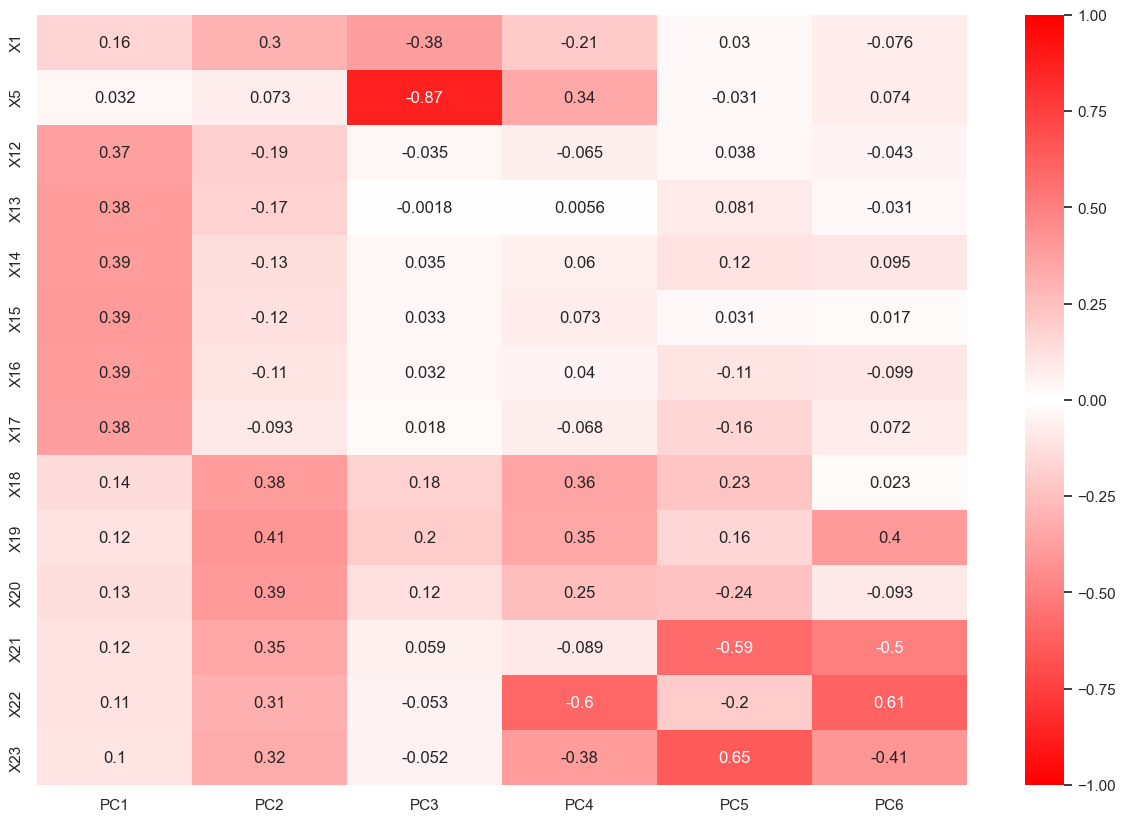

In [26]:
from matplotlib.colors import LinearSegmentedColormap


sns.set(rc = {'figure.figsize':(15,10)})
cmap = LinearSegmentedColormap.from_list(
    name='test', 
    colors=['red','white','red'])
sns.heatmap(pcs_comps.iloc[:,:6], vmin = -1, vmax = 1, cmap =cmap, annot= True)

Con el gráfico anterior es mucho más fácil identificar el impacto de cada variable en los componentes. Por ejemplo, se describe la relación de las variables para algunos de los componentes seleccionados:

* En el componente 1 se visualiza que las variables X12 a X17 son las que más impacto tienen sobre este. Esto significa que el componente 1 mide principalmente el monto del estado de cuenta de las tarjetas, y su magnitud tiene una dirección positiva.
* El componente 2 tiene magnitudes altas para las variables X18 a X23 y de dirección positiva, por lo que este componente mide mayormente el pago del periodo anterior.
* El componente 3 tiene una alta contribución de la variable X5, por lo que en este componente se concentra la información de la edad. En este caso, la dirección de la magnitud es negativa.


Ahora, veamos una tabla que resume la variable de mayor peso para cada componente principal, tomando en cuenta que esto debe hacerse con el valor absoluto de los pesos de los componentes.

In [27]:
id_max = pcs_comps.iloc[:,:6].abs().idxmax()
max_val = pcs_comps.iloc[:,:6].abs().max()

pd.DataFrame({"Variable with max weight": id_max, "Weight": max_val})

,Variable with max weight,Weight
PC1,X15,0.3916
PC2,X19,0.4079
PC3,X5,0.8699
PC4,X22,0.5967
PC5,X23,0.6482
PC6,X22,0.6135


Como se observa arriba, para el componente uno la variable que más contribuye, por tener un mayor peso, es X15. En el caso de X19 esta es la que más contribuye para el componente 2, mientras que la variable X5 es la que más impacta en el componente PC3. se observa que n el caso de las variables X22 y X23, tienen mayor peso para los componentes 4-6.

También de la tabla anterior se puede observar la magnitud de los pesos para cada una de las variables y la dirección, la cual es positiva en todos los casos. Mientras más grande sea el valor absoluto de los pesos, mayor será la contribución de esa variable para el cálculo del componente.

Ahora observemos las 3 variables que tienen menor peso para cada uno de los componentes.

In [28]:
id_min = pcs_comps.iloc[:,:6].abs().idxmin()
min_val = pcs_comps.iloc[:,:6].abs().min()

pd.DataFrame({"Variable with min weight": id_min, "Weight": min_val})

,Variable with min weight,Weight
PC1,X5,0.0320
PC2,X5,0.0727
PC3,X13,0.0018
PC4,X13,0.0056
PC5,X1,0.0301
PC6,X15,0.0166


#### **Paso 3: Identifique valores atípicos**

A continuación se construirá un diagrama de caja de los variables usadas para construir los componentes. Primero, escalamos los datos usando un minmax scaler para mejor visualización de los diagramas, puesto que al existir escalas muy diferentes el diagrama aparecerá muy distorsionado.

La razón por la cual se elige el MinMax Scaler es porque este no afecta la distribución de los datos. Solo cambia la escala de estos.

<AxesSubplot: >

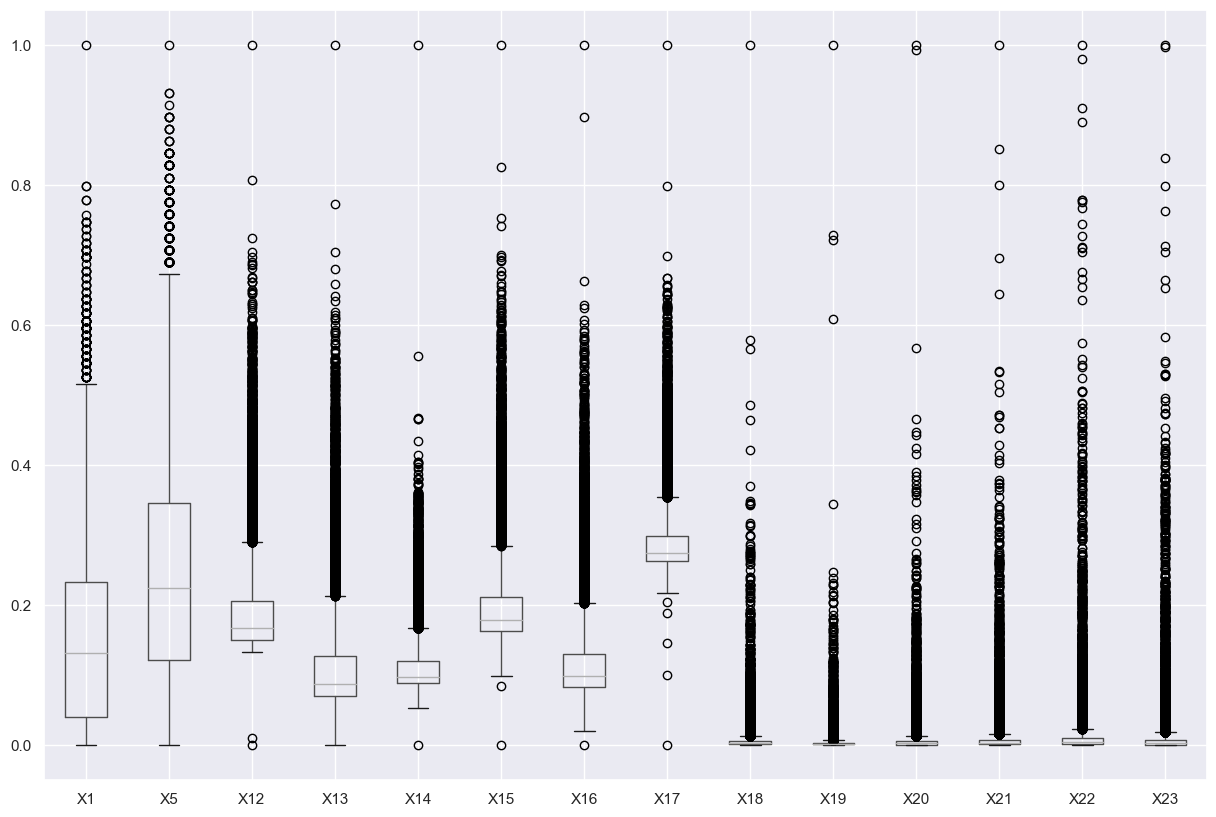

In [29]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()

pd.DataFrame(scaler.fit_transform(df_copy), columns = df_copy.columns).boxplot()


Del diagrama de caja anterior se observa que en la mayoría de los componentes existe presencia de valores atípicos. Aunque ya se hizo en análisis PCA, es importante realizar como primer paso la identificación de valores atípicos, puesto que estos valores extremos afectan el resultado de PCA.

A continuación se presenta un análisis del diagrama de caja:

* Las variables X1 y X5, aun presentando valores atípicos, son las que muestran las distribuciones menos dispersas con respecto a la media. Estas variables corresponden a la cantidad de crédito otorgado y a la edad de los clientes. Esto era de esperarse, pues aunque la media para ambos casos está por debajo del 25% de la distribución, no puede existir tanta variabilidad en edad y en el crédito permitido, en comparación con otros valores numéricos como la cantidad de crédito consumido en los meses anteriores.

* Las variables X12 a X23, que representan el crédito de consumo mensual y de cantidad cancelada por cada mes, tiene muchos más valores atípicos. Esto también era de esperarse, pues todos los clientes de todas las categorías de riesgo y de límite de crédito están agrupados en este dataset maestro. Además, existe mucha variabilidad debido también a que no se segmenta el conjunto de datos sobre otras variables, tales como edad, educación o historial crediticio familiar. Por eso es que estos atributos tienen tantos valores atípicos y por esto se dificulta tanto utilizar estos datos.

* Es necesario considerar generar una estrategia alrededor de los datos atípicos. El enfoque en mente es hacer que la distribución de cada atributo tenga menos dispersión, y esto se podría lograr con transformaciones sobre las variables o con una manera de sustituir los datos atípicos. Asimismo, también se podría segmentar el dataset en subconjuntos que dividan a los clientes en subclases, y trabajar los modelos desde ahí. Los datos atípicos pueden sesgar mucho a ciertos modelos, por lo que se recomendaría ajustar esta estrategia en conjunto con los expertos de dominio y con los responsables de las fuentes de datos.

#### **Parte 2 - Preguntas de Análisis**

1. ¿Cuál es el número de componentes mínimo y por qué?

 R: El número de componentes mínimo es 6, los cuales representan cerca del 80% de la variación. Sin embargo, es importante destacar que el número de componentes mínimo dependerá de la variación total que se desea que estos componentes expliquen. Lo recomendable es que este valor se encuentre por lo menos en 80%.

2. ¿Cuál es la variación de los datos que representan esos componentes?

R: Los 6 componentes seleccionados representan un 80% de la variación. Si quisiéramos obtener la misma variación usando las variables originales, tendríamos que utilizar un total de 11, como se mostró arriba.

1. ¿Cuál es la pérdida de información después de realizar PCA?

R: De seleccionarse 6 componentes, solo se estaría perdiendo cerca del 20% de la información.

4. De las variables originales, ¿Cuál tiene mayor y cuál tiene menor importancia en los componentes principales?

R: Las variables X14, X15, X16, X18, X19, X20, X22, X23 y X5 son las que tienen mayor importancia, ya que estas forman parte del Top 3 de las variables que más contribuyen en uno más de los 6 componentes que se extrajeron.

Con relación a las variables de menor importancia, serían aquellos que no se mencionaron arriba: X1, X17, X21, X12 y X13

5. ¿Cuándo se recomienda realizar un PCA y qué beneficios ofrece para Machine Learning? 

R: Se recomienda realizar un PCA cuando existe colinealidad entre las variables independientes. También se utiliza como un método de reducción para escoger aquellos factores que más contribuyen a la variación total de los datos.

Las ventajas de PCA para Machine Learning son:

* Menos factores a analizar, por lo que se requiere menos poder computacional para entrenar el modelo, principalmente cuando la cantidad de factores es muy alta.
* Elimina las dimensiones correlacionadas, lo cual se conoce como colinealidad.
* Ayuda a reducir el sobreentrenamiento de los datos, ya que elimina las características innecesarias.


**Fuentes:**

Jafari, R. (2022). Hands-on data preprocessing in python: Learn how to effectively prepare data for successful data analytics. Packt. 

Lee, W.-M. (2022, February 2). Using principal component analysis (PCA) for Machine Learning. Medium. Retrieved October 7, 2022, from https://towardsdatascience.com/using-principal-component-analysis-pca-for-machine-learning-b6e803f5bf1e 

